## 이미지 Super-resolution

In [1]:
%matplotlib inline
import numpy as np
import scipy.misc as misc
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim

# TensorFlow 내장 MNIST 데이터셋 모듈
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
def batch_norm_params(is_training):
    return {
        "decay": 0.9,
        "epsilon": 1e-5,
        "scale": True,
        "updates_collections": None,
        "is_training": is_training
    }


def arg_scope(is_training):
    with slim.arg_scope([slim.conv2d],
        weights_initializer=slim.variance_scaling_initializer(),
        activation_fn=tf.nn.relu,
        normalizer_fn=slim.batch_norm,
        normalizer_params=batch_norm_params(is_training),
        stride=1, padding="SAME"):
        with slim.arg_scope([slim.batch_norm],
                            **batch_norm_params(is_training)) as arg_scp:
            return arg_scp


def srnet(inputs, scope="srnet"):
    net = inputs
    with tf.variable_scope(scope) as scp:
        end_pts_collection = scp.name+"end_pts"
        with slim.arg_scope([slim.conv2d],
                            outputs_collections=end_pts_collection):
            net = slim.conv2d(net, 64, [3, 3],
                              normalizer_fn=None,
                              normalizer_params=None,
                              scope="conv1")

            net = slim.conv2d(net, 64, [3, 3], scope="conv2")
            net = slim.conv2d(net, 64, [3, 3], scope="conv3")
            
            net = slim.conv2d(net, 64, [3, 3], scope="conv4")
            net = slim.conv2d(net, 64, [3, 3], scope="conv5")
            
            net = slim.conv2d(net, 64, [3, 3], scope="conv6")
            net = slim.conv2d(net, 1, [3, 3],
                              activation_fn=tf.nn.tanh,
                              normalizer_fn=None,
                              normalizer_params=None,
                              scope="logit")

            end_pts = slim.utils.convert_collection_to_dict(end_pts_collection)

    return net, end_pts

In [3]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1])
labels = tf.placeholder(tf.float32, [None, 28, 28, 1])
is_training = tf.placeholder(tf.bool)

with slim.arg_scope(arg_scope(is_training)):
    logits, model = srnet(inputs)

In [4]:
learning_rate = 0.01

loss_op = tf.losses.mean_squared_error(labels, logits)
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

for step in range(2000):
    high_res, _ = mnist.train.next_batch(128)
    
    # 이미지 전처리 및 저해상도 변환
    high_res = high_res.reshape((-1, 28, 28))
    
    low_res = np.empty((high_res.shape[0], 28, 28))
    for i, image in enumerate(high_res):
        # 저해상도로 변환 뒤 원본과 크기 맞추는 과정
        low = misc.imresize(image, (7, 7)) / 255.0
        low_res[i] = misc.imresize(low, (28, 28)) / 255.0
        
    # [H, W, C] -> [N, H, W, C]
    high_res = high_res.reshape((-1, 28, 28, 1))
    low_res  = low_res.reshape((-1, 28, 28, 1))
        
    _, loss = sess.run([opt, loss_op], feed_dict={inputs: low_res, labels: high_res, is_training: True})
    
    if (step+1) % 500 == 0:
        print(step+1, loss)

500 0.0450217
1000 0.0118538
1500 0.0118664
2000 0.0107214


### 테스트

In [5]:
test_high = mnist.test.images[:5].reshape(-1, 28, 28)
test_low  = np.empty((test_high.shape[0], 28, 28))
for i, image in enumerate(test_high):
    low = misc.imresize(image, (7, 7)) / 255.0
    test_low[i] = misc.imresize(low, (28, 28)) / 255.0
    
# [H, W, C] -> [N, H, W, C]
test_high  = test_high.reshape((-1, 28, 28, 1))
test_low   = test_low.reshape((-1, 28, 28, 1))    
test_super = sess.run(logits, feed_dict={inputs:test_low, is_training:False})

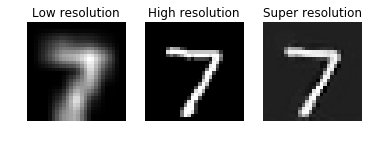

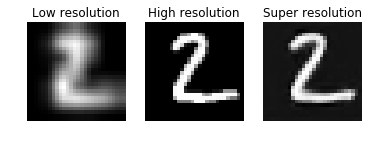

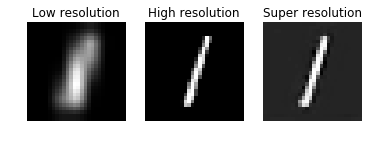

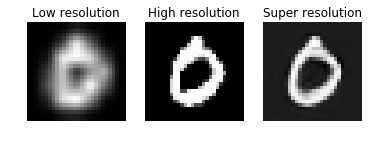

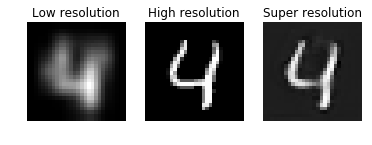

In [6]:
test_high  = test_high.reshape((-1, 28, 28))
test_low   = test_low.reshape((-1, 28, 28))
test_super = test_super.reshape((-1, 28, 28))

for i, (low, high, sup) in enumerate(zip(test_low, test_high, test_super)):
    fig = plt.figure()
    a = fig.add_subplot(1, 3, 1)
    a.axis("off")
    a.set_title("Low resolution")
    plt.imshow(low, cmap="gray")
    
    a = fig.add_subplot(1, 3, 2)
    a.axis("off")
    a.set_title("High resolution")
    plt.imshow(high, cmap="gray")
    
    a = fig.add_subplot(1, 3, 3)
    a.axis("off")
    a.set_title("Super resolution")
    plt.imshow(sup, cmap="gray")